In [1]:
import matplotlib.pyplot as plt
import random
import numpy as np
from skimage import transform
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Dense, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow import convert_to_tensor
from tensorflow.test import gpu_device_name
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [3]:
(x_train_init, y_train_init), (x_test_init, y_test_init) = cifar10.load_data()

In [4]:
x_train_init.shape

(50000, 32, 32, 3)

In [5]:
y_train_init.shape

(50000, 1)

[1]


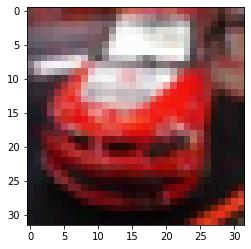

In [6]:
random_integer = random.randint(0, x_train_init.shape[0])

plt.imshow(x_train_init[random_integer,:])
print(y_train_init[random_integer, :])

In [7]:
y_train_one_hot = to_categorical(y_train_init, num_classes=10)
y_train_one_hot

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [8]:
x_train, x_val, y_train, y_val = train_test_split(x_train_init, y_train_one_hot, test_size=0.1)

In [9]:
x_train_tensor = convert_to_tensor(x_train)
y_train_tensor = convert_to_tensor(y_train)

x_val_tensor = convert_to_tensor(x_val)
y_val_tensor = convert_to_tensor(y_val)

In [10]:
x_train_tensor.shape

TensorShape([45000, 32, 32, 3])

In [11]:
y_train_tensor.shape

TensorShape([45000, 10])

In [12]:
class AlexNet(Model):
  def __init__(self, input_shape, num_classes):
    super(AlexNet, self).__init__()
    
    # self.conv1 = Conv2D(filters=96, kernel_size=11, strides=4, activation='relu', input_shape=input_shape)
    # self.max_pool_1 = MaxPooling2D(pool_size=(3, 3), strides=2)
    # self.conv2 = Conv2D(filters=256, kernel_size=5, activation='relu', padding='same')
    # self.max_pool_2 = MaxPooling2D(pool_size=3, strides=2)
    # self.conv3 = Conv2D(filters=384, kernel_size=3, activation='relu', padding='same')

    self.conv1 = Conv2D(filters=32, kernel_size=3, strides=1, activation='relu', input_shape=input_shape)
    self.max_pool_1 = MaxPooling2D(pool_size=2, strides=1)
    self.conv2 = Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')
    self.max_pool_2 = MaxPooling2D(pool_size=2, strides=1)
    self.conv3 = Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')

    # self.conv4 = Conv2D(filters=384, kernel_size=3, activation='relu', padding='same')
    # self.conv5 = Conv2D(filters=256, kernel_size=3, activation='relu', padding='same')
    # self.max_pool_2 = MaxPooling2D(pool_size=3, strides=2)

    self.conv4 = Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')
    self.conv5 = Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')
    self.max_pool_2 = MaxPooling2D(pool_size=2, strides=1)

    self.flatten = Flatten()

    # self.dense1 = Dense(units=4096, activation='relu')
    # self.dropout1 = Dropout(0.5)
    # self.dense2 = Dense(units=4096, activation='relu')
    # self.dropout2 = Dropout(0.5)
    # self.dense3 = Dense(units=1000, activation='relu')
    # self.dense4 = Dense(units=num_classes, activation='softmax')

    self.dense1 = Dense(units=512, activation='relu')
    self.dropout1 = Dropout(0.2)
    self.dense2 = Dense(units=256, activation='relu')
    self.dropout2 = Dropout(0.2)
    self.dense4 = Dense(units=num_classes, activation='softmax')

  def call(self, inputs):
    x = self.conv1(inputs)
    x = self.max_pool_1(x)
    x = self.conv2(x)
    x = self.max_pool_2(x)
    x = self.conv3(x)

    x = self.conv4(x)
    x = self.conv5(x)
    x = self.max_pool_2(x)

    x = self.flatten(x)

    x = self.dense1(x)
    x = self.dropout1(x)
    x = self.dense2(x)
    x = self.dropout2(x)
    x = self.dense4(x)

    return x

In [13]:
learning_rate = 0.001
batch_size = 128
epochs = 20

In [14]:
early_stop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=1)

In [15]:
model = AlexNet(input_shape=x_train_tensor.shape[1:], num_classes=y_train_one_hot.shape[1])
optimizer = Adam(learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
train_data_gen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.1, shear_range=0.1, rotation_range=2)
train_data_gen.fit(x_train_tensor)
train_gen = train_data_gen.flow(x_train_tensor, y_train_tensor, batch_size=batch_size)

val_data_gen = ImageDataGenerator(rescale=1./255)
val_data_gen.fit(x_val_tensor)
val_gen = val_data_gen.flow(x_val_tensor, y_val_tensor, batch_size=batch_size)

In [17]:
model.fit(train_gen, epochs=epochs, validation_data=val_gen, steps_per_epoch=len(x_train_tensor) // batch_size, callbacks=[early_stop_callback])

Epoch 1/20
351/351 [==============================] - 25s 71ms/step - loss: 1.6225 - accuracy: 0.3987 - val_loss: 1.3324 - val_accuracy: 0.5256
Epoch 2/20
351/351 [==============================] - 25s 71ms/step - loss: 1.2971 - accuracy: 0.5323 - val_loss: 1.1956 - val_accuracy: 0.5768
Epoch 3/20
351/351 [==============================] - 25s 71ms/step - loss: 1.1472 - accuracy: 0.5908 - val_loss: 0.9773 - val_accuracy: 0.6474
Epoch 4/20
351/351 [==============================] - 24s 70ms/step - loss: 1.0438 - accuracy: 0.6289 - val_loss: 0.9519 - val_accuracy: 0.6594
Epoch 5/20
351/351 [==============================] - 25s 70ms/step - loss: 0.9646 - accuracy: 0.6611 - val_loss: 0.9907 - val_accuracy: 0.6610
Epoch 6/20
351/351 [==============================] - 24s 69ms/step - loss: 0.8937 - accuracy: 0.6860 - val_loss: 0.8166 - val_accuracy: 0.7106
Epoch 7/20
351/351 [==============================] - 24s 70ms/step - loss: 0.8289 - accuracy: 0.7076 - val_loss: 0.7836 - val_accuracy:

In [20]:
x_test_norm = x_test_init / 255.0
x_test_tensor = convert_to_tensor(x_test_norm)
y_test_one_hot = to_categorical(y_test_init, num_classes=10)

In [21]:
model.evaluate(x=x_test_tensor, y=y_test_one_hot)

313/313 [==============================] - 1s 5ms/step - loss: 0.7693 - accuracy: 0.7403


[0.7692704796791077, 0.7402999997138977]